## 1. Import Related Modules and Packages

In [12]:
import tensorflow as tf
tfe = tf.contrib.eager
# Enable eager execution mode
tf.enable_eager_execution()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import requests

## 2. Hyperparameters

In [20]:
# A time step inputs one row of a image
# Number of time steps = number of rows
NUM_STEPS = 30
# Input  size = number of columns
INPUT_SIZE = 1
# Size of hidden states / LSTM units
HIDDEN_SIZE = 128
# Output size = 1 the predicted price in the next time step
OUTPUT_SIZE = 1

# Batch size
BATCH_SIZE = 64
# Number of epoches
INIT_EPOCH = 5
NUM_EPOCH = 10

# Learning rate
LEARNING_RATE = 0.001
LEARNING_RATE_DECAY = 0.99

## 3. Prepare for Data

### 3.1. Load Data

In [18]:
STOCK_PRICE_PATH = '000001.csv'
STOCK_PRICE_URL = "https://raw.githubusercontent.com/jaydu1/TensorFlow-Tutorial/master/14%20LSTM%20on%20Stock%20Prediction/000001.csv"
if not os.path.exists(STOCK_PRICE_PATH):
    r = requests.get(STOCK_PRICE_URL)
    print("Downloading ...", STOCK_PRICE_URL)
    with open(STOCK_PRICE_PATH, 'wb') as fin:
        fin.write(r.content)

In [3]:
STOCK_PRICE_PATH = '000001.csv'
data = pd.read_csv(STOCK_PRICE_PATH, encoding='gbk')
data

,日期,股票代码,名称,收盘价
0,2018-12-11,'000001,上证指数,2594.0881
1,2018-12-10,'000001,上证指数,2584.5822
2,2018-12-07,'000001,上证指数,2605.8876
3,2018-12-06,'000001,上证指数,2605.1813
4,2018-12-05,'000001,上证指数,2649.8051
5,2018-12-04,'000001,上证指数,2665.9577
6,2018-12-03,'000001,上证指数,2654.7980
7,2018-11-30,'000001,上证指数,2588.1875
8,2018-11-29,'000001,上证指数,2567.4434
9,2018-11-28,'000001,上证指数,2601.7365


In [4]:
rawSeq = np.array(data['收盘价'].sort_index(ascending=False).tolist())
seq = [np.array(rawSeq[i * INPUT_SIZE: (i + 1) * INPUT_SIZE])
       for i in range(len(rawSeq) // INPUT_SIZE)]




# split into groups of num_steps
X = np.array([seq[i: i + NUM_STEPS] for i in range(len(seq) - NUM_STEPS)])
y = np.array([seq[i + NUM_STEPS] for i in range(len(seq) - NUM_STEPS)])
    
train_size = int(len(X) * 0.9)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print('Training set:')
print('       Data :\t shape:', np.shape(x_train), '\t type:', x_train.dtype)
print('       Label:\t shape:', np.shape(y_train), '\t type:', y_train.dtype)
print('Testing set :')
print('       Data :\t shape:', np.shape(x_test), '\t type:', x_test.dtype)
print('       Label:\t shape:', np.shape(y_test), '\t type:', y_test.dtype)

Training set:
       Data :	 shape: (6131, 30, 1) 	 type: float64
       Label:	 shape: (6131, 1) 	 type: float64
Testing set :
       Data :	 shape: (682, 30, 1) 	 type: float64
       Label:	 shape: (682, 1) 	 type: float64


In [ ]:
normalized_seq = [seq[0] / seq[0][0] - 1.0] + [
        curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

# split into groups of num_steps
normalized_X = np.array([normalized_seq[i: i + NUM_STEPS] for i in range(len(normalized_seq) - NUM_STEPS)])
normalized_y = np.array([normalized_seq[i + NUM_STEPS] for i in range(len(normalized_seq) - NUM_STEPS)])
    
train_size = int(len(normalized_X) * 0.9)
normalized_x_train, normalized_x_test = normalized_X[:train_size], normalized_X[train_size:]
normalized_y_train, normalized_y_test = normalized_y[:train_size], normalized_y[train_size:]

print('Training set:')
print('       Data :\t shape:', np.shape(normalized_x_train), '\t type:', normalized_x_train.dtype)
print('       Label:\t shape:', np.shape(normalized_y_train), '\t type:', normalized_y_train.dtype)
print('Testing set :')
print('       Data :\t shape:', np.shape(normalized_x_test), '\t type:', normalized_x_test.dtype)
print('       Label:\t shape:', np.shape(normalized_y_test), '\t type:', normalized_y_test.dtype)

### 3.2. Generate Dataset

In [5]:
# Generate training Dataset
TrainDataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle per buffer_size
TrainDataset = TrainDataset.shuffle(buffer_size=300)
# Batch size
TrainDataset = TrainDataset.batch(BATCH_SIZE, drop_remainder=True)

# Generate testing Dataset
TestDataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Use the same config to generate normalized dataset
NormalizedTrainDataset = tf.data.Dataset.from_tensor_slices((normalized_x_train, normalized_y_train)).shuffle(buffer_size=300).batch(BATCH_SIZE, drop_remainder=True)
NormalizedTestDataset = tf.data.Dataset.from_tensor_slices((normalized_x_test, normalized_y_test)).batch(BATCH_SIZE, drop_remainder=True)

## 4. Build RNN

### 4.1. Build RNN

In [14]:
class Model(tf.keras.Model):
    def __init__(self, hidden_size, output_size):
        super(Model, self).__init__()
        self.units = hidden_size
        
        # If GPU available, use 'tf.contrib.cudnn_rnn.CudnnLSTM'
        self.lstm = tf.nn.rnn_cell.LSTMCell(num_units = hidden_size,   # units = HIDDEN_SIZE
                                            forget_bias=1.0,
                                            name='basic_lstm_cell'
                                            )

        self.fc = tf.keras.layers.Dense(output_size)
        # Here our model just outputs logits, to return the probability, add following codes:
        #    self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs):
        # output at last time step
        # output shape == (BATCH_SIZE, HIDDEN_SIZE) 
        outputs, final_state = tf.nn.dynamic_rnn(self.lstm, inputs,dtype=tf.float64)
        # final_state = (c_t, h_t)
       
        # The dense layer will output predictions for last time step
        # output shape after the dense layer == (BATCH_SIZE, OUTPUT_SIZE)
        prediction = self.fc(final_state[1])
        
        # To return the probability, add following codes:
        #    prediction = self.softmax(predictions)
        return prediction

### 4.2. Loss Function

In [15]:
def Loss(y_pred, y_true):
    '''
    Input:
        y_pred - [BATCH_SIZE, OUTPUT_SIZE]
        y      - [BATCH_SIZE, OUTPUT_SIZE]
    '''    
    return tf.reduce_mean(tf.square(y_pred - y_true), name="loss_mse")

### 4.3. Optimizer

In [16]:
# Using adam optimizer with default arguments
optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE)

### 4.4. Training

In [21]:
model = Model(HIDDEN_SIZE, OUTPUT_SIZE)

# Training loop
for epoch in range(NUM_EPOCH):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    for (batch, (x, y)) in enumerate(TrainDataset):
        with tf.GradientTape() as tape:
            # feeding the hidden state back into the model
            # This is the interesting step
            y_pred = model(x)
            loss = Loss(y_pred, y)

        grads = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))

        if batch % 50 == 0:
            print ('Epoch {:2d} - Batch {:5d} Loss {:.4f}'.format(epoch+1,
                                                          batch,
                                                          loss))
       
    print ('Epoch {:2d} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time taken for 1 epoch {} sec'.format(time.time() - start))
    
    # Testing at the end of every epoch
    y_pred = model(x_test)
    cost = Loss(y_pred, y_test)
    print('Test Cost: ', np.mean(cost))

Epoch  1 - Batch     0 Loss 0.0002
Epoch  1 - Batch    50 Loss 0.0002
Epoch  1 Loss 0.0004
Time taken for 1 epoch 19.62275195121765 sec
Test Cost:  9.344515785766776e-05
Epoch  2 - Batch     0 Loss 0.0001
Epoch  2 - Batch    50 Loss 0.0001
Epoch  2 Loss 0.0005
Time taken for 1 epoch 20.165257215499878 sec
Test Cost:  0.00019899050037407306
Epoch  3 - Batch     0 Loss 0.0173
Epoch  3 - Batch    50 Loss 0.0001
Epoch  3 Loss 0.0005
Time taken for 1 epoch 20.714064836502075 sec
Test Cost:  9.48655847879417e-05
Epoch  4 - Batch     0 Loss 0.0001
Epoch  4 - Batch    50 Loss 0.0002
Epoch  4 Loss 0.0005
Time taken for 1 epoch 20.442069053649902 sec
Test Cost:  9.295527417982195e-05
Epoch  5 - Batch     0 Loss 0.0001
Epoch  5 - Batch    50 Loss 0.0002
Epoch  5 Loss 0.0005
Time taken for 1 epoch 19.82199788093567 sec
Test Cost:  9.942357464359833e-05
Epoch  6 - Batch     0 Loss 0.0003
Epoch  6 - Batch    50 Loss 0.0003
Epoch  6 Loss 0.0007
Time taken for 1 epoch 19.668965101242065 sec
Test Cost:

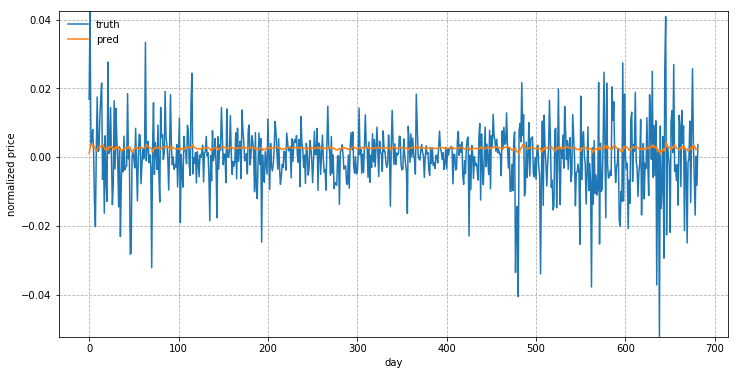

In [30]:
def plotSamples(y_true, y_pred):
    def _flatten(seq):
        return np.array([x for y in seq for x in y])

    truths = _flatten(y_test)[:]
    preds = (_flatten(y_pred) * 1)[:]
    days = range(len(truths))[:]

    plt.figure(figsize=(12, 6))
    plt.plot(days, truths, label='truth')
    plt.plot(days, preds, label='pred')
    plt.legend(loc='upper left', frameon=False)
    plt.xlabel("day")
    plt.ylabel("normalized price")
    plt.ylim((min(truths), max(truths)))
    plt.grid(ls='--')